In [1]:
import json
import numpy as np
from copy import deepcopy
from collections import Counter

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from utils.data_io import *
from utils.common import *

import seaborn as sns
cmap = sns.color_palette("flare", as_cmap=True)

In [2]:
# Calculate signal changes between time intervals
def calculate_delta(data, timestamp, max_interval=24):
    delta = []
    valid_idx = [i for i in range(len(data)) 
                 if data[i] is not None and data[i]==data[i]]
    
    delta += [None] * valid_idx[0]
    for i in range(len(valid_idx)-1):
        interval = valid_idx[i+1] - valid_idx[i]
        if interval < max_interval:
            delta += [(data[valid_idx[i+1]] - data[valid_idx[i]]) / interval] * interval
        else:
            delta += [None] * interval
    delta += [None] * (len(timestamp) - valid_idx[-1])
    return delta

In [3]:
patients_grouped_by_diagnosis = np.load('processed/patient_grouped_by_diagnosis.npy', allow_pickle=True).item()

# Check correlation between blood pressure changes
- CVP
- systolic blood pressure

In [4]:
dx = 'Cardiac arrest (with or without respiratory arrest; for respiratory arrest see Respiratory System)'
patients_id = patients_grouped_by_diagnosis[dx]
patient = {}
for pid in patients_id:
    data = load_patient_data_by_id(pid)
    cvp = data['vitalPeriodic']['cvp']
    cvp = [val for val in cvp if val is not None and val==val]
    bp_sys = data['vitalPeriodic']['systemicsystolic']
    bp_sys = [val for val in bp_sys if val is not None and val == val]
    if len(cvp) and len(bp_sys):
        patient[pid] = {}
        patient[pid]['age'] = data['patient']['age'][0]
        patient[pid]['gender'] = data['patient']['gender'][0]
        patient[pid]['unitdischargestatus'] = data['patient']['unitdischargestatus'][0]
        patient[pid]['unitlengthofstay'] = data['patient']['unitdischargeoffset'][0]

        patient[pid]['vitalaperiodic'] = sort_dict(data['vitalAperiodic'], key='observationoffset')
        patient[pid]['vitalperiodic'] = sort_dict(data['vitalPeriodic'], key='observationoffset')
patients_id_cvp = list(patient.keys())

## Example patient blood pressure data

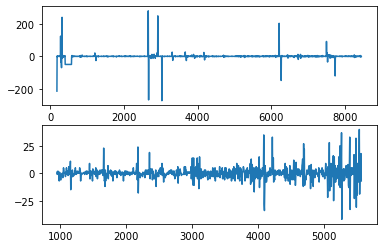

In [5]:
pid = patients_id_cvp[350]

cvp = patient[pid]['vitalperiodic']['cvp']
bp_sys = patient[pid]['vitalperiodic']['systemicsystolic']
ts = patient[pid]['vitalperiodic']['observationoffset']

max_interval = 24     # calculate only delta of measurements where the time interval is within 2 hour 

delta_cvp = calculate_delta(cvp, ts, max_interval)
delta_sys = calculate_delta(bp_sys, ts, max_interval)

fig, ax = plt.subplots(2)
ax[0].plot(ts, delta_cvp)
ax[1].plot(ts, delta_sys)

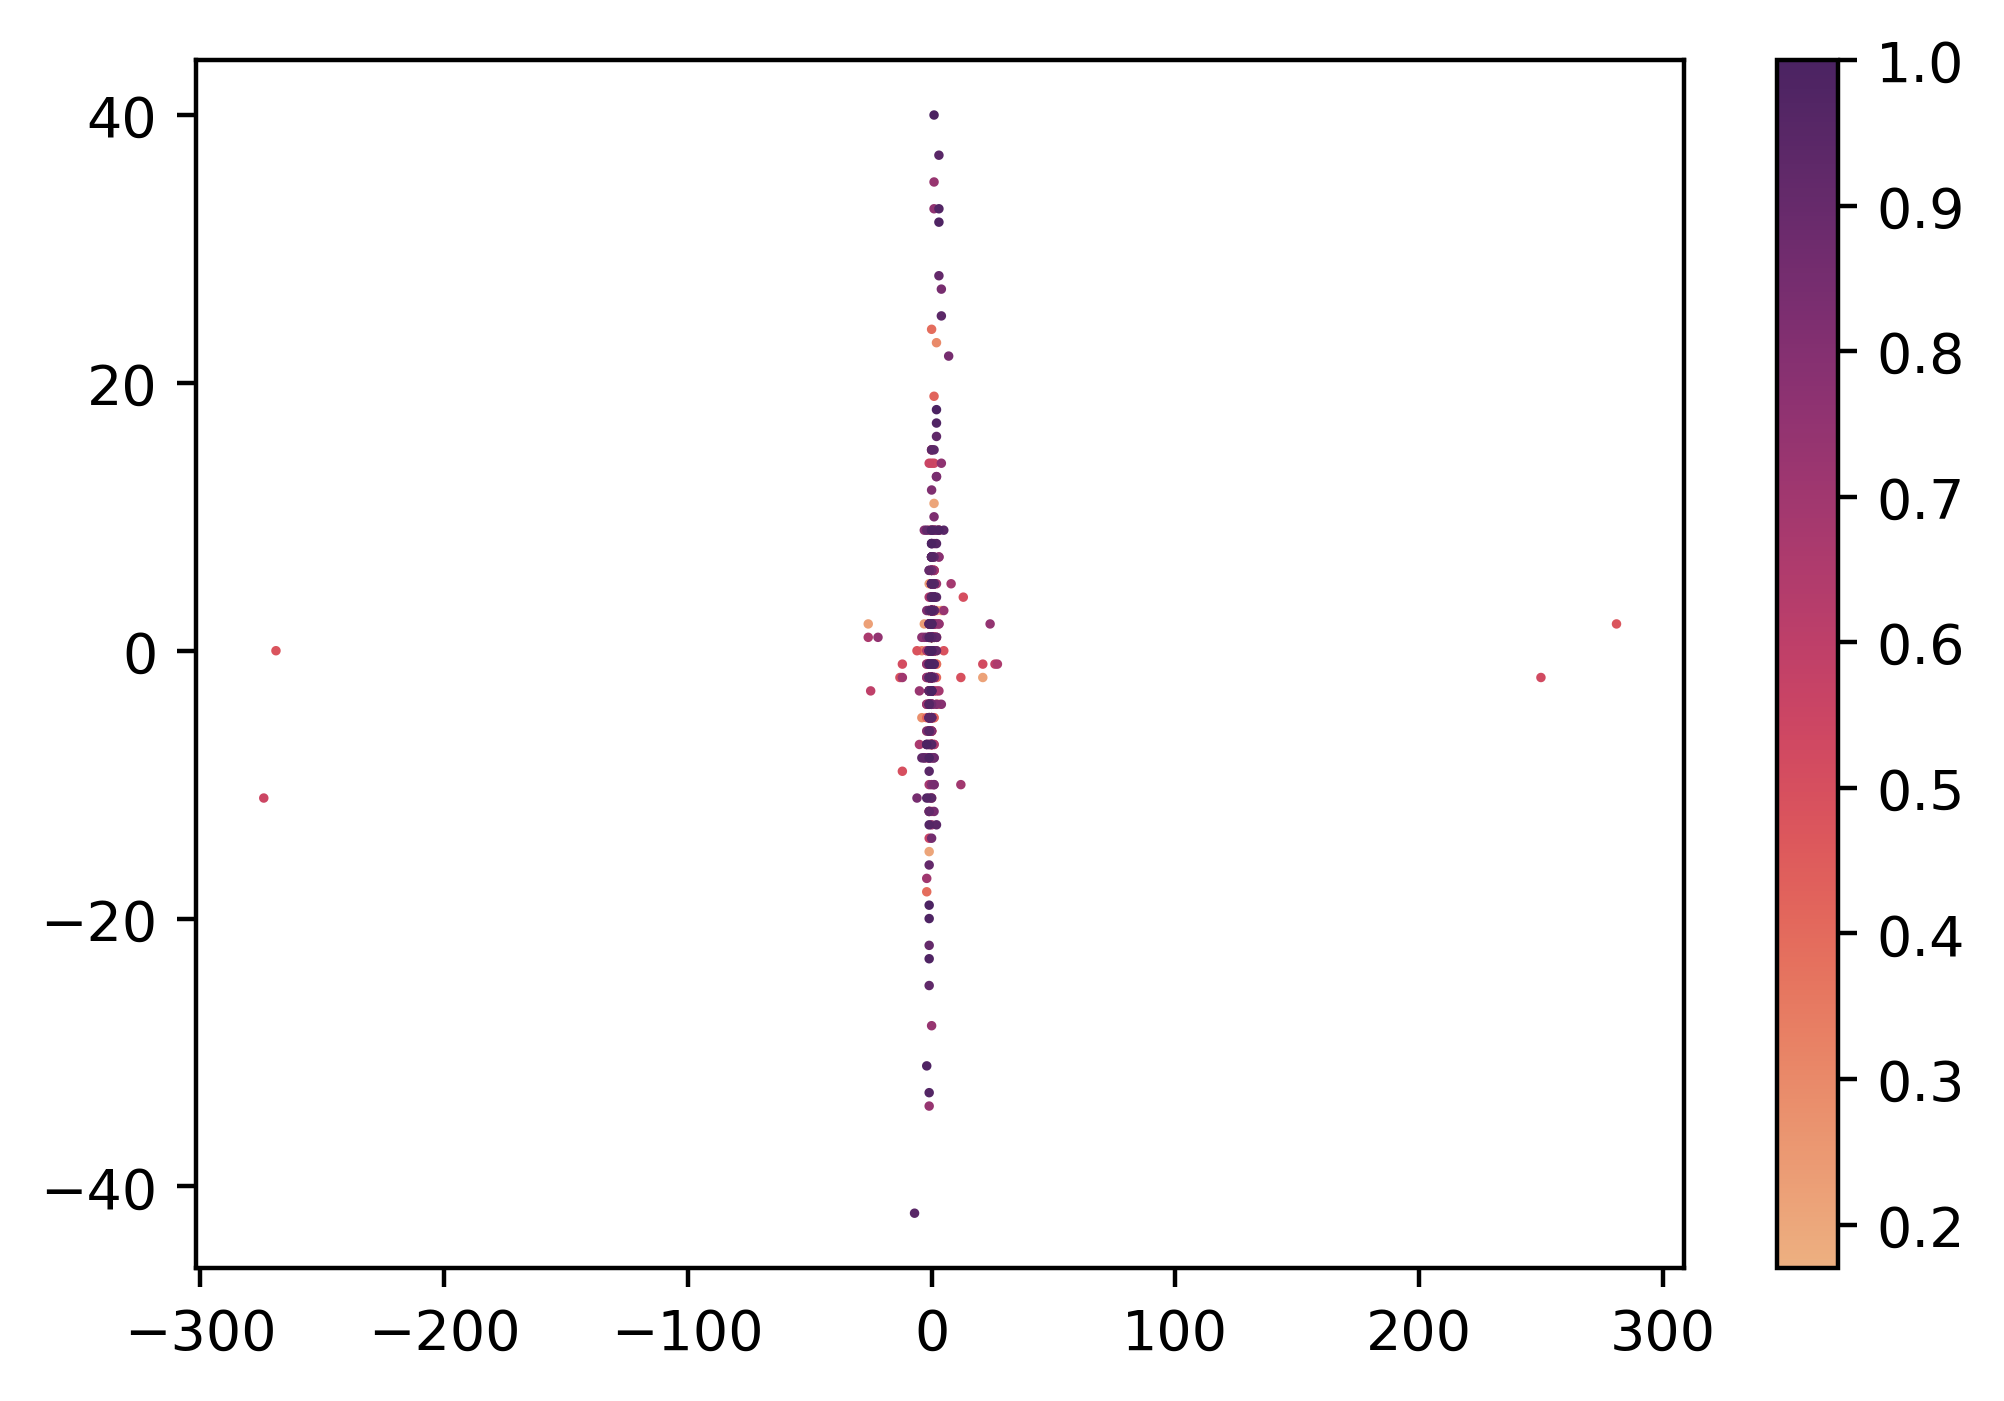

In [6]:
ts_norm = np.array(ts)
delta_cvp = np.array(delta_cvp)
delta_sys = np.array(delta_sys)
delta_cvp[delta_cvp==None] = np.nan
delta_sys[delta_sys==None] = np.nan

delta_cvp_valid = [delta_cvp[i] for i in range(len(ts)) if ~np.isnan(delta_cvp[i]) and ~np.isnan(delta_sys[i])]
delta_sys_valid = [delta_sys[i] for i in range(len(ts)) if ~np.isnan(delta_cvp[i]) and ~np.isnan(delta_sys[i])]
ts_valid = [ts[i] for i in range(len(ts)) if ~np.isnan(delta_cvp[i]) and ~np.isnan(delta_sys[i])]

if np.min(ts_norm) < 0:
    ts_valid += abs(np.min(ts_valid))
ts_valid = ts_valid/np.max(ts_valid)

fig, ax = plt.subplots()
fig.set_dpi(400)
points = ax.scatter(delta_cvp_valid, delta_sys_valid, c=ts_valid, marker='.', s=2, cmap=cmap)
fig.colorbar(points)

## Plot BP correlation for heart attack patients

In [7]:
delta_cvp_alive = []
delta_sys_alive = []
ts_alive = []
delta_cvp_expired = []
delta_sys_expired = []
ts_expired = []

max_interval = 24     # calculate only delta of measurements where the time interval is within 2 hour 

for pid in patients_id_cvp:
    cvp = patient[pid]['vitalperiodic']['cvp']
    bp_sys = patient[pid]['vitalperiodic']['systemicsystolic']
    ts = patient[pid]['vitalperiodic']['observationoffset']

    delta_cvp = calculate_delta(cvp, ts, max_interval)
    delta_sys = calculate_delta(bp_sys, ts, max_interval)

    ts_norm = np.array(ts)
    delta_cvp = np.array(delta_cvp)
    delta_sys = np.array(delta_sys)
    delta_cvp[delta_cvp==None] = np.nan
    delta_sys[delta_sys==None] = np.nan
    
#     valid_idx = np.logical_and(~np.isnan(delta_cvp),  ~np.isnan(delta_sys))
    
#     delta_cvp_valid = delta_cvp[valid_idx]
#     delta_sys_valid = delta_sys[valid_idx]
#     ts_valid = ts[valid_idxd_idx]
    ts_valid = [ts[i] for i in range(len(ts)) if ~np.isnan(delta_cvp[i]) and ~np.isnan(delta_sys[i])]
    if len(ts_valid)/len(ts) > 0.1:
        delta_cvp_valid = [delta_cvp[i] for i in range(len(ts)) if ~np.isnan(delta_cvp[i]) and ~np.isnan(delta_sys[i])]
        delta_sys_valid = [delta_sys[i] for i in range(len(ts)) if ~np.isnan(delta_cvp[i]) and ~np.isnan(delta_sys[i])]

        if np.min(ts_norm) < 0:
            ts_valid += abs(np.min(ts_valid))
        ts_valid = ts_valid/np.max(ts_valid)

        if patient[pid]['unitdischargestatus'] == 'Alive':
            delta_cvp_alive.extend(delta_cvp_valid)
            delta_sys_alive.extend(delta_sys_valid)
            ts_alive.extend(ts_valid)
        if patient[pid]['unitdischargestatus'] == 'Expired':
            delta_cvp_expired.extend(delta_cvp_valid)
            delta_sys_expired.extend(delta_sys_valid)
            ts_expired.extend(ts_valid)

In [8]:
len(delta_cvp_alive), len(delta_cvp_expired)

(188188, 98771)

Text(0.5, 1.0, 'Heart Arrest: Alive Patients')

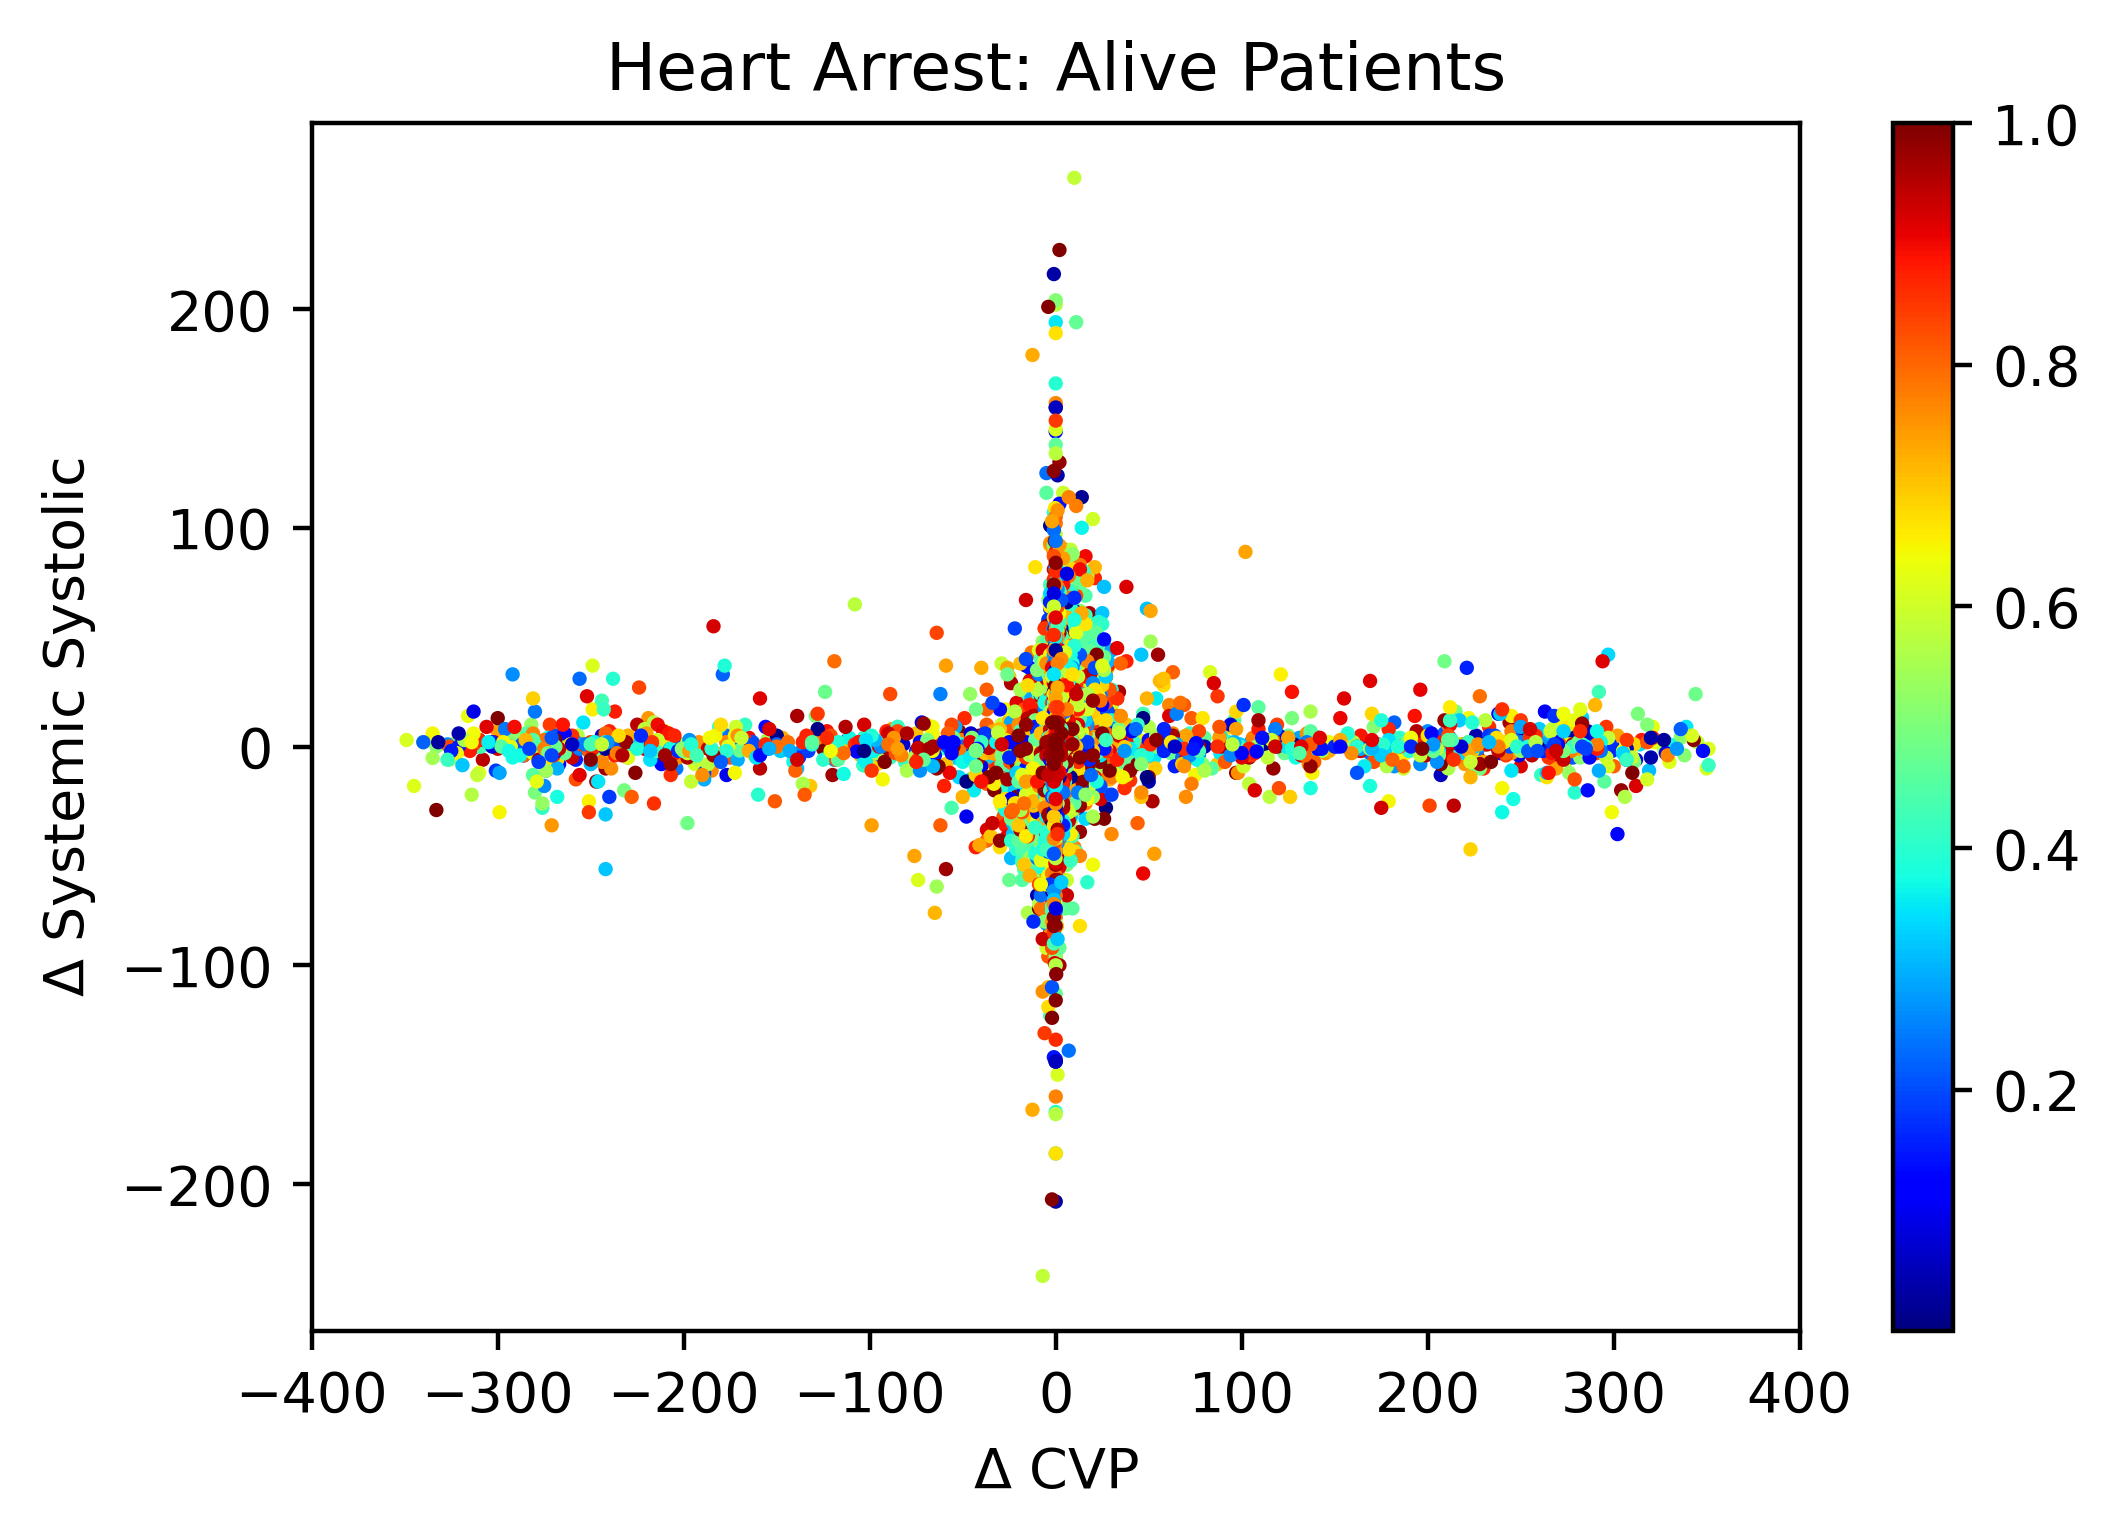

In [9]:
%matplotlib inline

fig, ax = plt.subplots()
fig.set_dpi(400)
points = ax.scatter(delta_cvp_alive, delta_sys_alive, c=ts_alive, marker='.', s=10, cmap='jet')
fig.colorbar(points)

ax.set_xlim([-400, 400])
ax.set_xlabel(r'$\Delta$ CVP')
ax.set_ylabel(r'$\Delta$ Systemic Systolic')
ax.set_title('Heart Arrest: Alive Patients')

Text(0, 0.5, '$\\Delta$ Systemic Systolic')

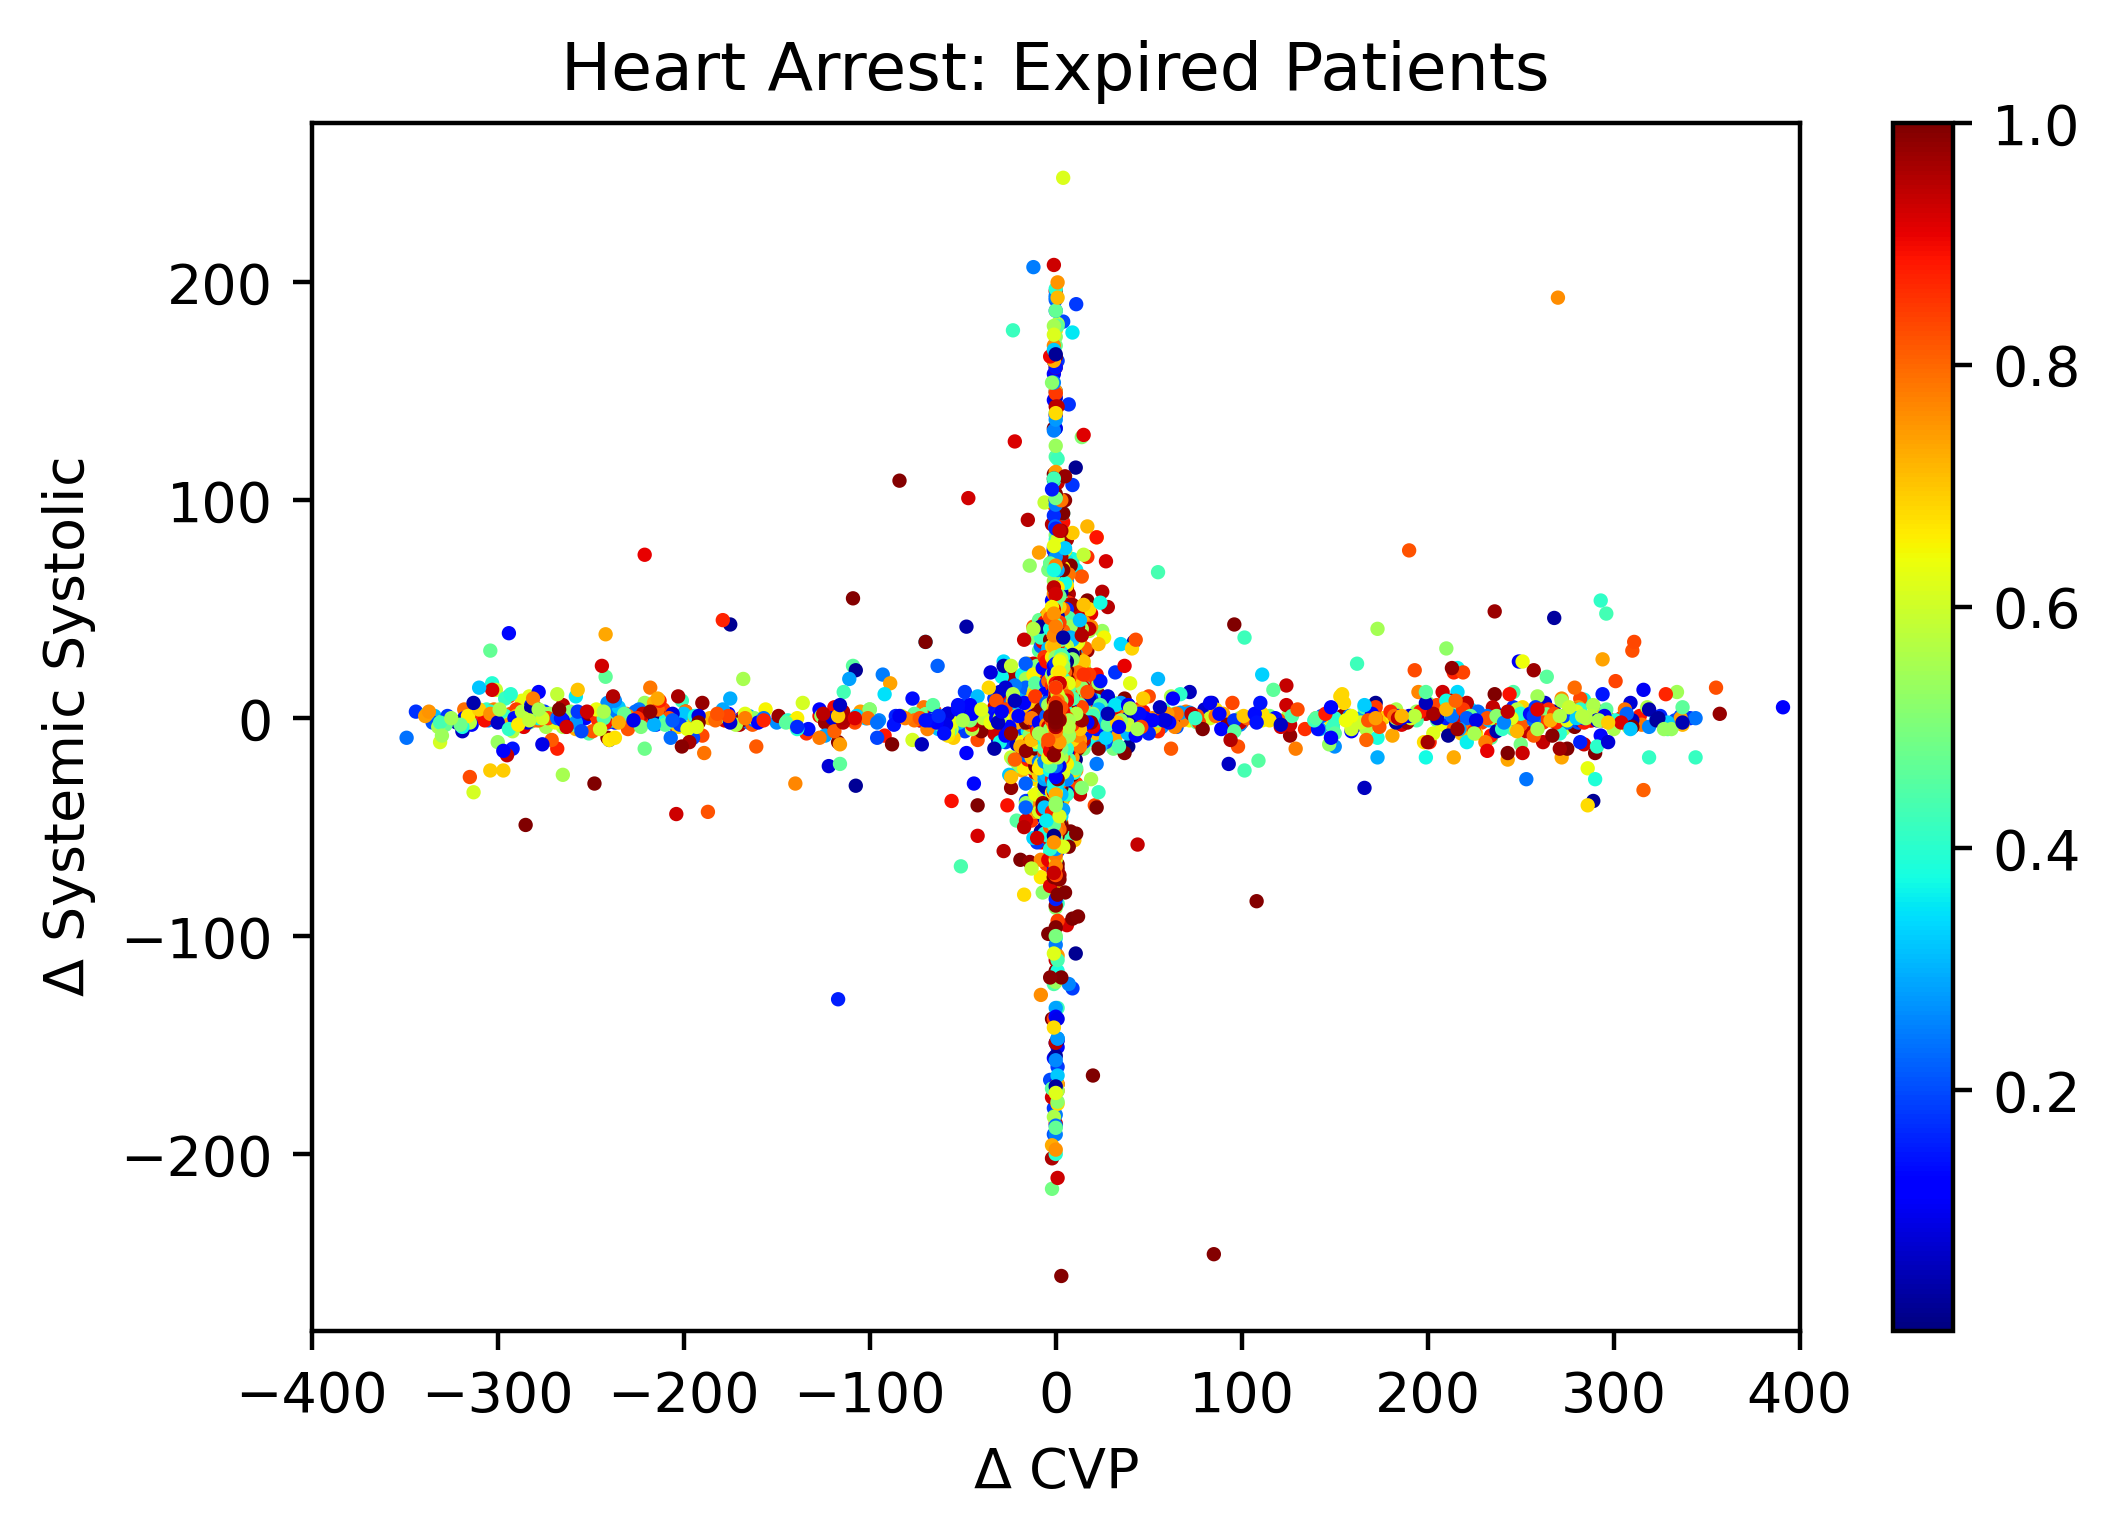

In [10]:
fig, ax = plt.subplots()
fig.set_dpi(400)
points = ax.scatter(delta_cvp_expired, delta_sys_expired, c=ts_expired, marker='.', s=10, cmap='jet')
fig.colorbar(points)

ax.set_xlim([-400, 400])
ax.set_title('Heart Arrest: Expired Patients')
ax.set_xlabel(r'$\Delta$ CVP')
ax.set_ylabel(r'$\Delta$ Systemic Systolic')


Text(0.5, 0, 'Systemic BP')

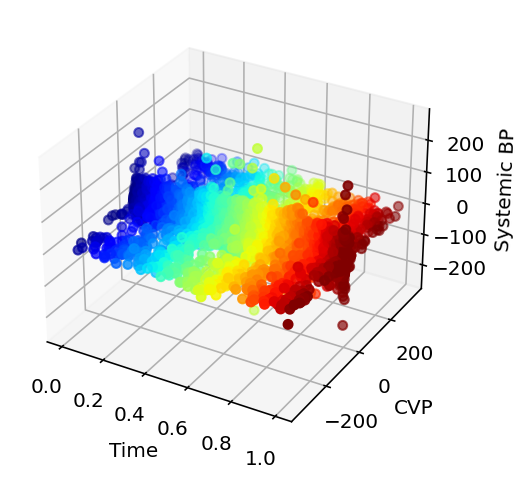

In [11]:
%matplotlib qt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(ts_alive, delta_cvp_alive, delta_sys_alive, c = ts_alive, cmap='jet')
ax.set_xlabel('Time')
ax.set_ylabel('CVP')
ax.set_zlabel('Systemic BP')

Text(0.5, 0, 'Systemic BP')

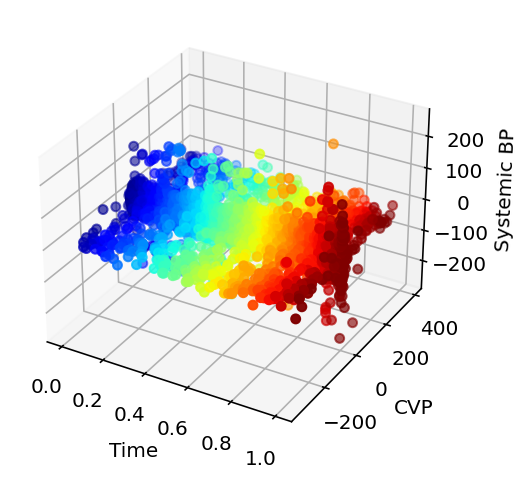

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(ts_expired, delta_cvp_expired, delta_sys_expired, c = ts_expired, cmap='jet')
ax.set_xlabel('Time')
ax.set_ylabel('CVP')
ax.set_zlabel('Systemic BP')

## Ratio between different BP changes

In [13]:
import warnings
warnings.filterwarnings('ignore')

(-500.0, 500.0)

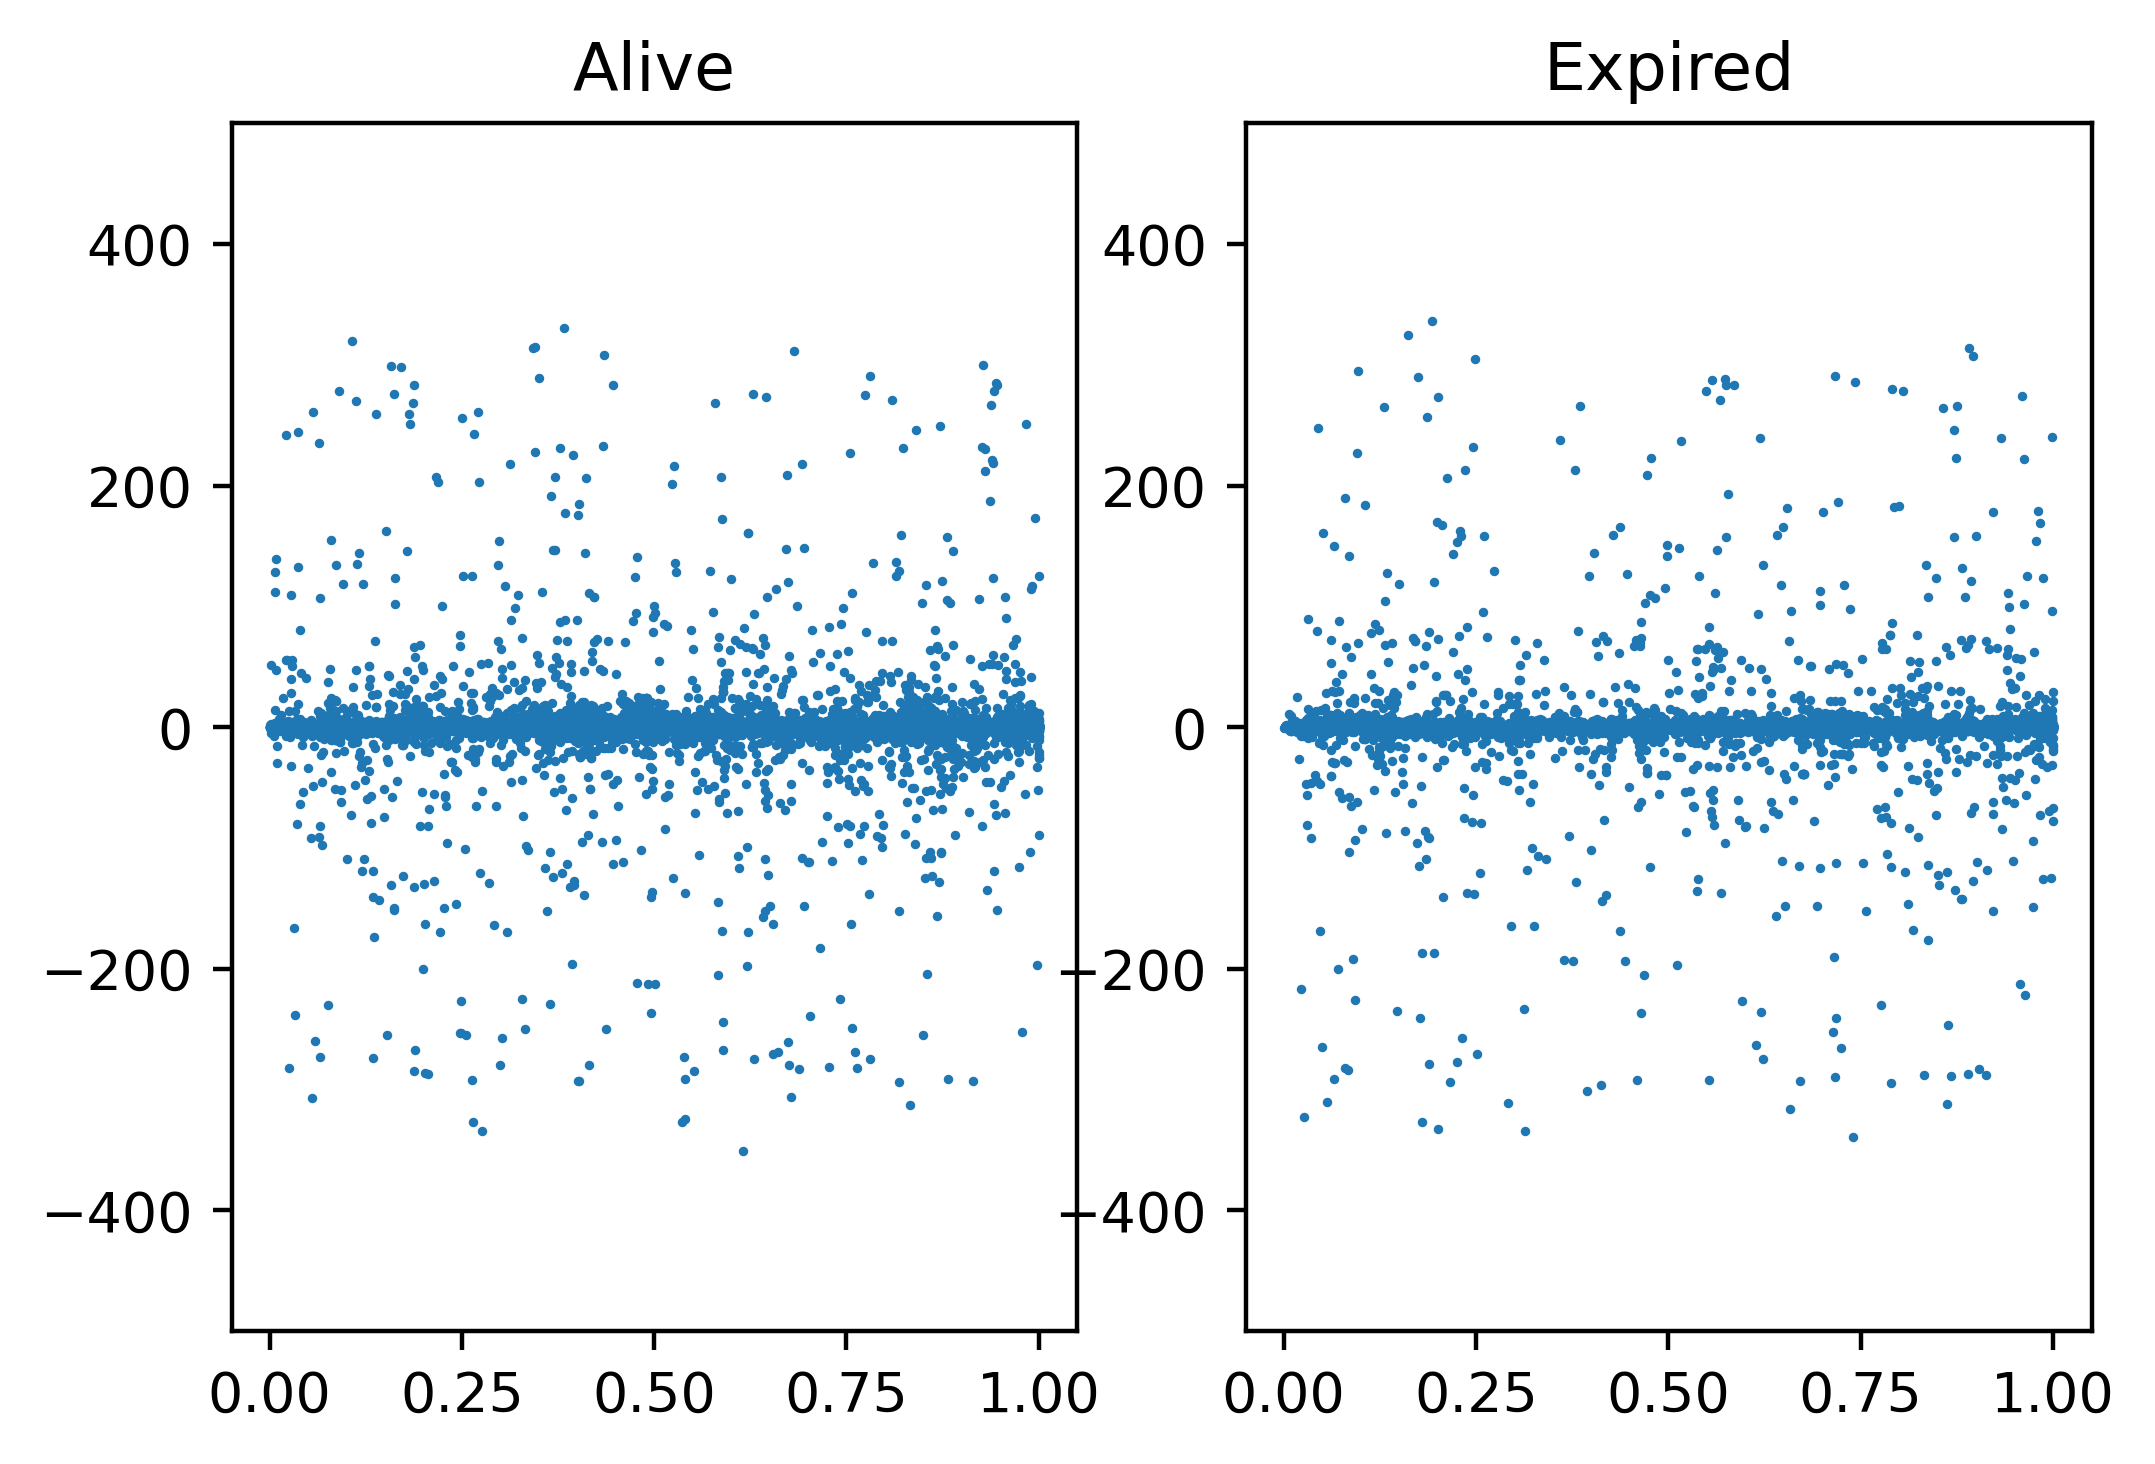

In [14]:
fig, ax = plt.subplots(1,2)
fig.set_dpi(400)

ax[0].scatter(ts_alive, np.array(delta_cvp_alive)/np.array(delta_sys_alive), marker='.', s=2, )
ax[1].scatter(ts_expired, np.array(delta_cvp_expired)/np.array(delta_sys_expired), marker='.', s=2, )

ax[0].set_title('Alive')
ax[1].set_title('Expired')
ax[0].set_ylim([-500, 500])
ax[1].set_ylim([-500, 500])

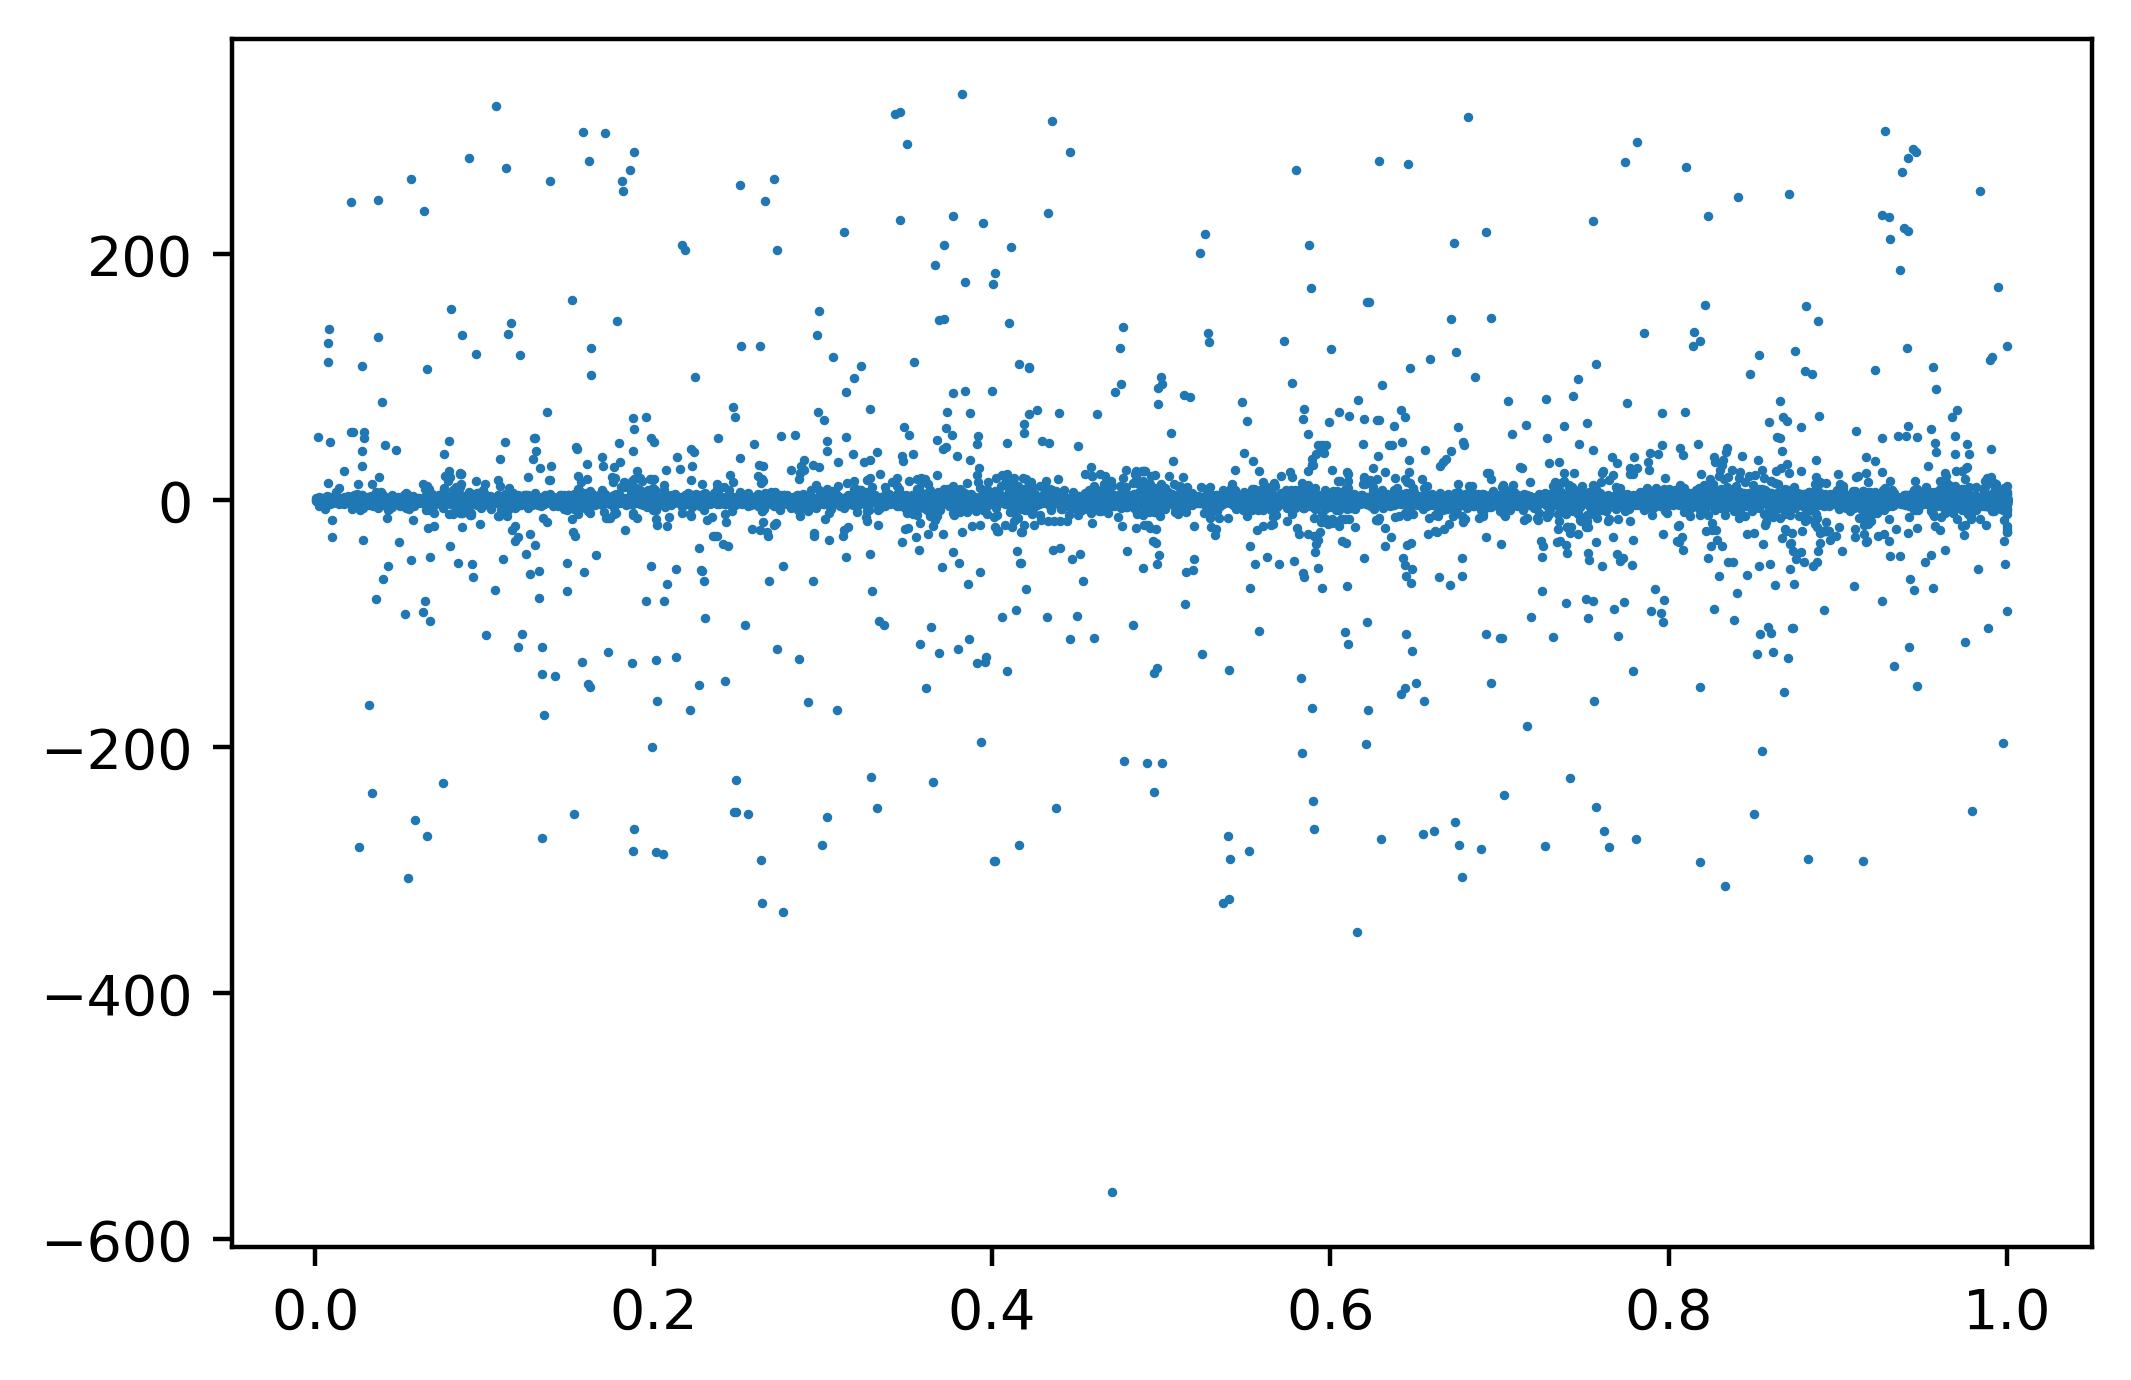

In [15]:
fig, ax = plt.subplots()
fig.set_dpi(400)
ax.scatter(ts_alive, np.array(delta_cvp_alive)/np.array(delta_sys_alive), marker='.', s=2)